<a href="https://colab.research.google.com/github/REZAKAZAZI00/Assessment_Backend/blob/master/nbaert12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install -q datasets transformers accelerate evaluate nrclex nltk


In [14]:
import numpy as np
import torch
from torch import nn
import math
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    BertModel,
    BertPreTrainedModel,
    TrainingArguments,
    Trainer,
    default_data_collator,
)
import evaluate
from nrclex import NRCLex
import nltk


In [15]:
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
import nltk
nltk.download("punkt_tab")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
dataset = load_dataset("nbertagnolli/counsel-chat")
full_ds = dataset["train"]

temp = full_ds.train_test_split(test_size=0.3, seed=42)
train_ds = temp["train"]
temp_2 = temp["test"].train_test_split(test_size=0.5, seed=42)
val_ds = temp_2["train"]
test_ds = temp_2["test"]


Repo card metadata block was not found. Setting CardData to empty.


In [17]:
EMOTION_LABELS = [
    "anger", "fear", "anticipation", "trust", "surprise",
    "sadness", "joy", "disgust", "negative", "positive"
]

label2id = {e: i for i, e in enumerate(EMOTION_LABELS)}
id2label = {i: e for e, i in label2id.items()}


In [18]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if text is None:
        return ""

    text = str(text).lower().strip()
    if text == "":
        return ""

    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


def nrc_features_and_label(text):
    cleaned = clean_text(text)

    if cleaned == "":
        return [0.0] * 10, None

    emo = NRCLex(cleaned)
    raw = emo.raw_emotion_scores

    counts = [raw.get(e, 0) for e in EMOTION_LABELS]
    total = sum(counts)

    if total == 0:
        return [0.0] * 10, None

    vec = [c / total for c in counts]
    label = EMOTION_LABELS[int(np.argmax(counts))]

    return vec, label


In [19]:
def add_lexicon_and_label(example):
    title = example.get("questionTitle") or ""
    question = example.get("questionText") or ""
    answer = example.get("answerText") or ""

    full_text = title + " " + question + " " + answer

    vec, label = nrc_features_and_label(full_text)

    example["lexicon_feats"] = vec
    example["emotion_label"] = label if label else "no_emotion"

    return example

In [20]:
train_labeled = train_ds.map(add_lexicon_and_label)
val_labeled   = val_ds.map(add_lexicon_and_label)
test_labeled  = test_ds.map(add_lexicon_and_label)

train_labeled = train_labeled.filter(lambda x: x["emotion_label"] != "no_emotion")
val_labeled   = val_labeled.filter(lambda x: x["emotion_label"] != "no_emotion")
test_labeled  = test_labeled.filter(lambda x: x["emotion_label"] != "no_emotion")


Map:   0%|          | 0/1942 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1942 [00:00<?, ? examples/s]

Filter:   0%|          | 0/416 [00:00<?, ? examples/s]

Filter:   0%|          | 0/417 [00:00<?, ? examples/s]

In [21]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LENGTH = 256


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
def preprocess_function(examples):
    texts = [
        (t or "") + " " + (q or "") + " [SEP] " + (a or "")
        for t, q, a in zip(
            examples["questionTitle"],
            examples["questionText"],
            examples["answerText"]
        )
    ]

    tokenized = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH,
    )

    tokenized["labels"] = [label2id[x] for x in examples["emotion_label"]]
    tokenized["lexicon_feats"] = examples["lexicon_feats"]

    return tokenized


train_proc = train_labeled.map(
    preprocess_function,
    batched=True,
    remove_columns=train_labeled.column_names
)

val_proc = val_labeled.map(
    preprocess_function,
    batched=True,
    remove_columns=val_labeled.column_names
)

test_proc = test_labeled.map(
    preprocess_function,
    batched=True,
    remove_columns=test_labeled.column_names
)

train_proc.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels", "lexicon_feats"]
)

val_proc.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels", "lexicon_feats"]
)

test_proc.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels", "lexicon_feats"]
)


Map:   0%|          | 0/1938 [00:00<?, ? examples/s]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

Map:   0%|          | 0/415 [00:00<?, ? examples/s]

In [23]:
from transformers.models.bert.modeling_bert import BertSelfAttention
import torch
import torch.nn as nn
import math

class LexiconGuidedSelfAttention(BertSelfAttention):
    def __init__(self, config):
        super().__init__(config)

        self.lex_q = nn.Linear(10, config.hidden_size)
        self.lex_k = nn.Linear(10, config.hidden_size)
        self.lex_v = nn.Linear(10, config.hidden_size)

        self.current_lexicon = None

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

    def set_lexicon(self, lexicon_feats):
        self.current_lexicon = lexicon_feats

    def transpose_for_scores(self, x):
        new_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_value=None,
        output_attentions=False,
        **kwargs
    ):
        Q = self.query(hidden_states)
        K = self.key(hidden_states)
        V = self.value(hidden_states)

        if self.current_lexicon is not None:
            lex = self.current_lexicon.unsqueeze(1)
            Q = Q + self.lex_q(lex)
            K = K + self.lex_k(lex)
            V = V + self.lex_v(lex)

        query_layer = self.transpose_for_scores(Q)
        key_layer   = self.transpose_for_scores(K)
        value_layer = self.transpose_for_scores(V)

        scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        scores = scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            scores = scores + attention_mask

        probs = nn.Softmax(dim=-1)(scores)
        probs = self.dropout(probs)

        context = torch.matmul(probs, value_layer)
        context = context.permute(0, 2, 1, 3).contiguous()
        new_context_shape = context.size()[:-2] + (self.all_head_size,)
        context = context.view(*new_context_shape)

        if output_attentions:
            return (context, probs)

        return (context,)


In [24]:
from transformers.models.bert.modeling_bert import BertAttention

class LexiconGuidedBertAttention(BertAttention):
    def __init__(self, config):
        super().__init__(config)
        self.self = LexiconGuidedSelfAttention(config)


In [25]:

from transformers.modeling_outputs import SequenceClassifierOutput

class ExactNBert(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.bert = BertModel(config)

        for layer in self.bert.encoder.layer:
            layer.attention = LexiconGuidedBertAttention(config)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.post_init()

    def forward(
        self, input_ids=None, attention_mask=None, token_type_ids=None,
        lexicon_feats=None, labels=None, num_items_in_batch=None
    ):

        if lexicon_feats is not None:
            for layer in self.bert.encoder.layer:
                layer.attention.self.set_lexicon(lexicon_feats)

        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )



In [26]:
model = ExactNBert.from_pretrained(
    MODEL_NAME,
    num_labels=len(EMOTION_LABELS)
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ExactNBert were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.attention.self.lex_k.bias', 'bert.encoder.layer.0.attention.self.lex_k.weight', 'bert.encoder.layer.0.attention.self.lex_q.bias', 'bert.encoder.layer.0.attention.self.lex_q.weight', 'bert.encoder.layer.0.attention.self.lex_v.bias', 'bert.encoder.layer.0.attention.self.lex_v.weight', 'bert.encoder.layer.1.attention.self.lex_k.bias', 'bert.encoder.layer.1.attention.self.lex_k.weight', 'bert.encoder.layer.1.attention.self.lex_q.bias', 'bert.encoder.layer.1.attention.self.lex_q.weight', 'bert.encoder.layer.1.attention.self.lex_v.bias', 'bert.encoder.layer.1.attention.self.lex_v.weight', 'bert.encoder.layer.10.attention.self.lex_k.bias', 'bert.encoder.layer.10.attention.self.lex_k.weight', 'bert.encoder.layer.10.attention.self.lex_q.bias', 'bert.encoder.layer.10.attention.self.lex_q.weight', 'bert.encoder.layer.10.attention.self.lex_v.bias', 'bert.

In [27]:
accuracy  = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall    = evaluate.load("recall")
f1        = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="weighted")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="weighted")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
    }


In [28]:
training_args = TrainingArguments(
    output_dir="exact-nbert",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=5,
    weight_decay=0.04,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_proc,
    eval_dataset=val_proc,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.007800,0.660241,0.557636,0.660241,0.582874
2,No log,0.954935,0.689157,0.604908,0.689157,0.626876
3,No log,0.907392,0.693976,0.651637,0.693976,0.671467
4,No log,0.975812,0.708434,0.664944,0.708434,0.681671
5,0.707700,1.010754,0.693976,0.647537,0.693976,0.668252


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

TrainOutput(global_step=610, training_loss=0.6290985764050093, metrics={'train_runtime': 646.3691, 'train_samples_per_second': 14.991, 'train_steps_per_second': 0.944, 'total_flos': 1279391221094400.0, 'train_loss': 0.6290985764050093, 'epoch': 5.0})

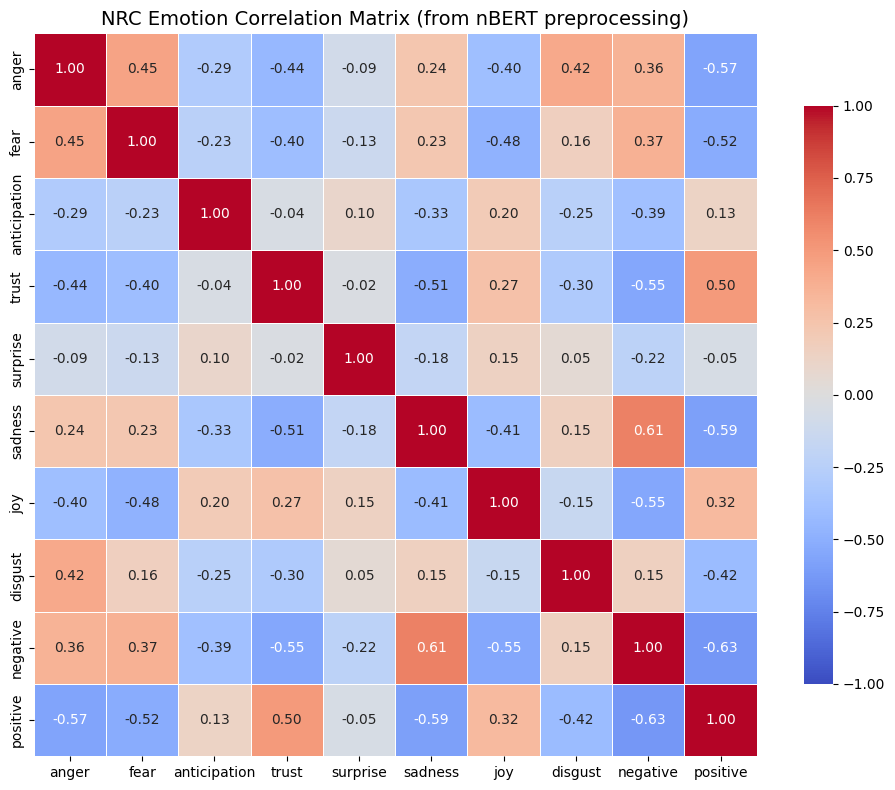

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

lexicon_matrix = np.array(train_labeled["lexicon_feats"])

df_lex = pd.DataFrame(lexicon_matrix, columns=EMOTION_LABELS)

corr = df_lex.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .8}
)
plt.title("NRC Emotion Correlation Matrix (from nBERT preprocessing)", fontsize=14)
plt.tight_layout()
plt.show()
